In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, random
from sklearn.metrics import confusion_matrix, classification_report

# Set seeds for reproducibility
tf.random.set_seed(123)
np.random.seed(123)
random.seed(123)

In [2]:
# Configuration parameters
DATASET_DIR =  "Dataset"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)      # ResNet101 expects 224x224 images
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10

In [3]:
# Load training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
print("Classes found:", train_ds.class_names)

Found 9677 files belonging to 2 classes.
Using 7742 files for training.
Found 9677 files belonging to 2 classes.
Using 1935 files for validation.
Classes found: ['Cancer', 'Non-Cancer']


In [4]:
# Calculate class weights from the training dataset
train_class_counts = [0, 0]
for _, labels in train_ds.unbatch():
    train_class_counts[int(labels.numpy())] += 1
total_train = sum(train_class_counts)
class_weights = {i: total_train / (2 * train_class_counts[i]) for i in range(2)}
print("Calculated class weights:", class_weights)

Calculated class weights: {0: 2.959480122324159, 1: 0.6016474976686353}


In [ ]:
# Access the class names from the dataset
class_names = train_ds.class_names

for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

0: Cancer
1: Non-Cancer


In [7]:
# Build the model using pre-trained ResNet101
base_model = tf.keras.applications.ResNet101(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False  # Freeze the base model

inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# Preprocess input for ResNet
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x, training=False)

# Replace GlobalAveragePooling2D with Flatten layer
x = tf.keras.layers.Flatten()(x)

# Add two Dense layers
x = tf.keras.layers.Dense(128, activation='relu')(x)  # First Dense layer
x = tf.keras.layers.Dense(64, activation='relu')(x)   # Second Dense layer

# Final output layer with sigmoid activation for binary classification
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = tf.keras.Model(inputs, outputs)

# Compile and train the model (initial phase)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [6]:
# Define callbacks: ModelCheckpoint and EarlyStopping
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',         # file to save the model
    monitor='val_accuracy',           # monitor validation accuracy
    mode='max',                       # mode 'max' because we want to maximize accuracy
    save_best_only=True,              # only save when validation accuracy improves
    verbose=1
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',               # monitor validation loss
    patience=5,                       # stop after 5 epochs with no improvement
    verbose=1
)

In [ ]:
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=INITIAL_EPOCHS,
                    class_weight=class_weights,
                    callbacks=[checkpoint_cb, early_stopping_cb],
                    shuffle = True) # shuffle

Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6631 - loss: 0.5983
Epoch 1: val_accuracy improved from -inf to 0.87093, saving model to best_model.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 702s 3s/step - accuracy: 0.6636 - loss: 0.5979 - val_accuracy: 0.8709 - val_loss: 0.3919
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8859 - loss: 0.3762
Epoch 2: val_accuracy improved from 0.87093 to 0.89726, saving model to best_model.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 645s 2s/step - accuracy: 0.8860 - loss: 0.3761 - val_accuracy: 0.8973 - val_loss: 0.3214
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9070 - loss: 0.3223
Epoch 3: val_accuracy improved from 0.89726 to 0.91843, saving model to best_model.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 671s 3s/step - accuracy: 0.9070 - loss: 0.3223 - val_accuracy: 0.9184 - val_loss: 0.2737
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9204 - loss: 0.2910
Epoch 4: val_accuracy improved from 0.9184

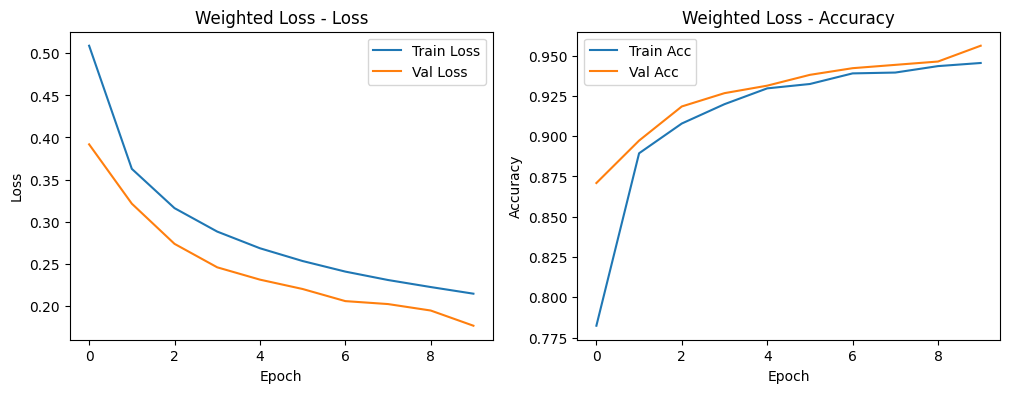

In [8]:
# Plot initial training results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Weighted Loss - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Weighted Loss - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Evaluation on the validation set
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32").flatten())
y_true = np.array(y_true)
y_pred = np.array(y_pred)
accuracy = np.mean(y_true == y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

When using Keras’s image_dataset_from_directory, the subdirectories are sorted alphabetically and assigned labels in that order. In your case, the two folders are named "Cancer" and "Non-Cancer":

Alphabetical Order: "Cancer" comes before "Non-Cancer."
1. Thus, images in the Cancer folder are assigned label 0.
2. Images in the Non-Cancer folder are assigned label 1.

In [10]:
from sklearn.metrics import classification_report
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cancer", "Non-Cancer"]))

Validation Accuracy: 95.61%
Confusion Matrix:
[[ 270   41]
 [  44 1582]]
Classification Report:
              precision    recall  f1-score   support

      Cancer       0.86      0.87      0.86       311
  Non-Cancer       0.97      0.97      0.97      1626

    accuracy                           0.96      1937
   macro avg       0.92      0.92      0.92      1937
weighted avg       0.96      0.96      0.96      1937



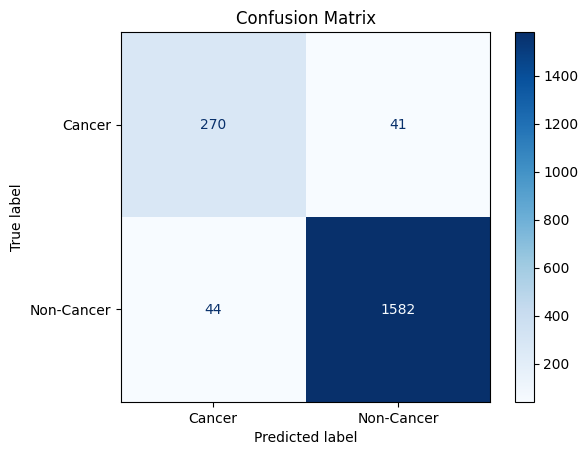

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create a display object using the computed confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancer', 'Non-Cancer'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Fine-tuning phase: Unfreeze the last 10 layers of the base model
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 10
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks for the fine-tuning phase
checkpoint_ft_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_finetune.keras',  # Save fine-tuned model here
    monitor='val_accuracy',             # Monitor validation accuracy
    mode='max',                         # Higher accuracy is better
    save_best_only=True,                # Only save the model when validation accuracy improves
    verbose=1
)
early_stopping_ft_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',                 # Monitor validation loss
    patience=5,                         # Stop if no improvement after 5 epochs
    verbose=1
)

# Train the model (fine-tuning phase) with callbacks
history_ft = model.fit(train_ds, 
                       validation_data=val_ds,
                       epochs=INITIAL_EPOCHS + FINE_TUNE_EPOCHS,
                       initial_epoch=INITIAL_EPOCHS,
                       class_weight=class_weights,
                       callbacks=[checkpoint_ft_cb, early_stopping_ft_cb],
                       shuffle=True)  # Shuffle the training data for better generalization)

Epoch 11/20


243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9369 - loss: 0.2118
Epoch 11: val_accuracy improved from -inf to 0.96902, saving model to best_model_finetune.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 865s 3s/step - accuracy: 0.9369 - loss: 0.2117 - val_accuracy: 0.9690 - val_loss: 0.1237
Epoch 12/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9660 - loss: 0.1394
Epoch 12: val_accuracy improved from 0.96902 to 0.97057, saving model to best_model_finetune.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 618s 3s/step - accuracy: 0.9660 - loss: 0.1393 - val_accuracy: 0.9706 - val_loss: 0.1021
Epoch 13/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9795 - loss: 0.0948
Epoch 13: val_accuracy improved from 0.97057 to 0.97574, saving model to best_model_finetune.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 656s 3s/step - accuracy: 0.9795 - loss: 0.0948 - val_accuracy: 0.9757 - val_loss: 0.0814
Epoch 14/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9879 - loss: 0.0691
Epoch 14: val_accura

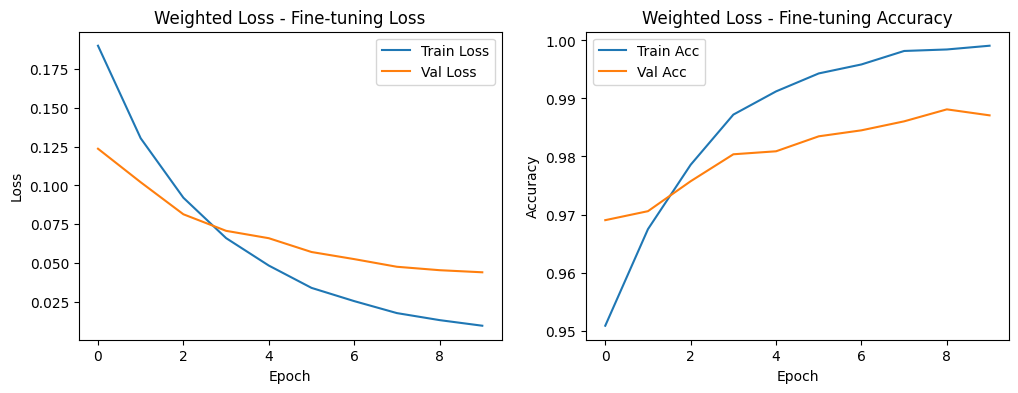

In [14]:
# Plot fine-tuning results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Val Loss')
plt.title("Weighted Loss - Fine-tuning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_ft.history['accuracy'], label='Train Acc')
plt.plot(history_ft.history['val_accuracy'], label='Val Acc')
plt.title("Weighted Loss - Fine-tuning Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [15]:
# Evaluation on the validation set
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32").flatten())
y_true = np.array(y_true)
y_pred = np.array(y_pred)
accuracy = np.mean(y_true == y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [16]:
from sklearn.metrics import classification_report
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cancer", "Non-Cancer"]))

Validation Accuracy: 98.71%
Confusion Matrix:
[[ 296   15]
 [  10 1616]]
Classification Report:
              precision    recall  f1-score   support

      Cancer       0.97      0.95      0.96       311
  Non-Cancer       0.99      0.99      0.99      1626

    accuracy                           0.99      1937
   macro avg       0.98      0.97      0.98      1937
weighted avg       0.99      0.99      0.99      1937



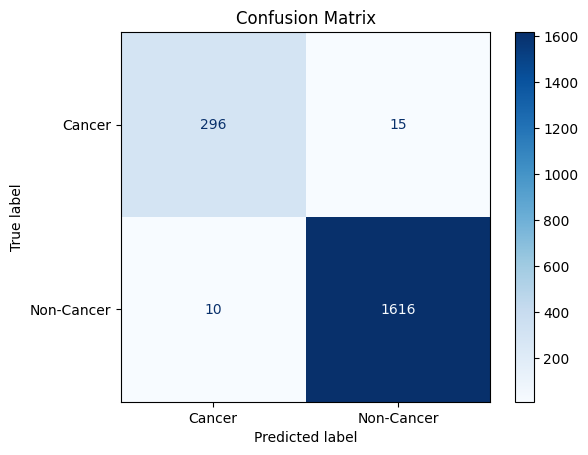

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create a display object using the computed confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancer', 'Non-Cancer'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()